Please fill in your name and that of your teammate.

You: Ahonon Gobi Parfait

Teammate:

# Introduction

Welcome to the sixth lab. Last week we attacked classification problems expanding the concept of LDA, interpreting the data as generated from probability distributions, into Naïve Bayes. Today we follow the same plan from the perspective of the _margin_, starting with the Perceptron expanding it into the Support Vector Machine.

You will notice we will not implement the learning algorithm this time, because SVMs are solved through quadratic programming and that is not fun. But please feel free to check out quadratic programming yourself if you are interested.

Today we focus on the ample new glossary, then implementing the SVM objective function, and using off-the-shelf optimizers for training. Enjoy!

## Load your libraries

**FROM NOW ON:** take a habit of loading your default libraries, plotting style and external tools at the top of the file (as I do here). I will not mention it further in the next labs, it will be up to you to load what you need.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
sns.set(rc={'figure.figsize':(8,6)}, style="whitegrid")

### How to pass the lab?

Below you find the exercise questions. Each question awarding points is numbered and states the number of points like this: **[0pt]**. To answer a question, fill the cell below with your answer (markdown for text, code for implementation). Incorrect or incomplete answers are in principle worth 0 points: to assign partial reward is only up to teacher discretion. Over-complete answers do not award extra points (though they are appreciated and will be kept under consideration). Save your work frequently! (`ctrl+s`)

**You need at least 18 points (out of 27 available) to pass** (66%).

# 1. Fundamentals

#### 1.1 **[1pt]** Write the equation for the margin (use latex).

The margin ($\gamma$) for a data point $(x, y)$ with respect to a decision boundary defined by an affine linear function $f(x) = \langle w, x \rangle + b$ can be expressed as:

$\[
\gamma = y \cdot f(x)
\]$


#### 1.2 **[2pt]** Write the equation for the maximum margin separation (use latex), then explain it in English below.

The equation for the maximum margin separation in SVMs can be written as follows:

$\[
\arg \max_{\mathbf{w}, b} \{ \gamma \}
\] $

subject to the constraint:

$\[
y_i \cdot (\langle \mathbf{w}, \mathbf{x}_i \rangle + b) \geq \gamma
\]$

where $\gamma$ represents the margin, $\mathbf{w}$ is the weight vector, $b$ is the bias term, $\mathbf{x}_i$ is a data point, and $y_i$ is its corresponding label.

This optimization problem seeks to maximize the margin $\gamma$ while ensuring that all data points are correctly classified with a margin greater than or equal to $\gamma$. The decision boundary is defined by the hyperplane $\langle \mathbf{w}, \mathbf{x} \rangle + b = 0$, where $\mathbf{w}$ and $b$ are parameters determined by solving the optimization problem.


#### 1.3 **[1pt]** When is an *example* (in a dataset) considered a Support Vector? Write its definition using latex, then explain it in English.

An example $(\mathbf{x}_i, y_i)$ is considered a Support Vector if its margin with respect to the decision boundary is equal to 1, i.e., $y_i \cdot (\langle \mathbf{w}, \mathbf{x}_i \rangle + b) = 1$.

Explanation: 
A Support Vector is a data point in the dataset that sits close to the decision boundary in SVMs. These points define the margin, which is the space between different classes. Support Vectors have a margin of exactly 1 and are important because they help determine the best decision boundary and affect how other points are classified.


#### 1.4 **[1pt]** Explain in English why SVMs ignore examples that are not Support Vectors.

Support Vector Machines (SVMs) ignore examples that are not Support Vectors because these examples do not influence the construction of the decision boundary.

Support Vectors are the data points that lie closest to the decision boundary, and they play a crucial role in determining the position and orientation of the boundary. These are the only points that directly affect the margin and thus the classification of new data points.

#### 1.5 **[2pt]** Define each of the following concepts (in English): Quadratic Program, Slack Variable, Multiobjective Optimization, with your own words.


Tip: if you want to write something with your own words, you can read a description of it, then put the description away and immediately try to explain it again as if to someone that has no background on it. This of course only works if you have understood the concepts, else you'll find yourself just changing words but reusing the sentences: please avoid that (as the goal is to force you to understand the concepts).  
Incidentally, this is also why studying in pairs/groups works (typically) better: explaining concepts to each other forces you to confront how much did you really understand of it.

Definition: 
**Quadratic Program:** It's a math problem where we try to find the smallest or biggest answer to a math puzzle, and we have to follow some rules. Imagine it like a game where we want to get the best score, but we have to play by certain rules. The rules involve equations that have squares in them, like $x^2$, and we're trying to find the best value for x while following those rules.

**Slack Variable:** Imagine you're drawing a line to separate two groups of points, but some points are on the wrong side of the line. Slack variables are like little "mistake allowances" we give to these points. They let us be a bit flexible so that not every point has to be on the correct side of the line. This helps us find a good line that separates the groups as best as possible, even if it's not perfect.

**Multiobjective Optimization**: Imagine you have more than one goal you want to achieve, but these goals might conflict with each other. Multiobjective optimization is like finding a compromise between these different goals. It's about finding the best solution that balances all the objectives, even if they sometimes compete with each other.

#### 1.6 **[3pt]** Write the full formula for the Soft Margin SVM (geometric approach; use latex), then explain in English the role of the hyperparameter C (particularly: what do high or low values mean for the SVM).

$\[
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \frac{1}{2} ||\mathbf{w}||^2 + C \sum_{i=1}^{n} \xi_i
\]$

subject to the constraints:

$\[
y_i (\langle \mathbf{w}, \mathbf{x}_i \rangle + b) \geq 1 - \xi_i, \quad \xi_i \geq 0 \quad \text{for } i = 1, 2, ..., n
\]$


In the Soft Margin SVM, the hyperparameter C is like a knob that controls how much we care about getting the training data points right versus having a big gap between the classes. 

- If C is high, it means we really want to get the training points right, even if it means having a smaller gap between the classes. So, the model tries hard to fit the data points, even if it's a bit messy.
  
- If C is low, it means we care more about having a big gap between the classes, even if it means some training points might not be perfectly classified. So, the model focuses more on finding a clear gap, even if it doesn't fit the data points perfectly.

So, choosing the right value for C is like finding the balance between fitting the training data well and having a clear gap between the classes.

#### 1.7 **[2pt]** Write the objective function for the Soft Margin SVM (use latex) using the Regularized Empirical Risk Minimization approach and a Squared Hinge Loss for `L(m)`.

This is no copy-paste, think! Do you remember the difference between the Loss on a _point_, the Loss on a _boundary_, and the _Risk_? You need these concepts super clear for the exam!


Lke my own explanation of those:
- **Loss on a point**: This is like looking at how well the model did for just one piece of data. If the model got it wrong, it adds to the loss for that point.

- **Loss on a boundary**: This is when we look at how well the model did for all the data points together. It's like adding up all the losses for each point to see how good the model is overall.

- **Risk**: This is the big picture. It's like stepping back and looking at how well the model did for the whole dataset. It tells us how good the model is overall, considering all the points together.

**The objective function for the Soft Margin SVM**
With the Squared Hinge Loss denoted as $L(m)$, where $m$ is the margin, the objective function can be expressed as follows:

$ \[
\min_{\mathbf{w}, b, \boldsymbol{\xi}} \frac{1}{2} ||\mathbf{w}||^2 + C \sum_{i=1}^{n} L(y_i \cdot (\langle \mathbf{w}, \mathbf{x}_i \rangle + b))
\]
$


# 2. Soft Margin SVM

- Following what we learned in the last exercise: **all** of the questions below need to be solved using Pandas and **no Python loops** (`for`, `while`, etc).
- Let's classify the Iris dataset with a hand-made SVM. Working with margins though means we need to set up once again for **binary classification**. Last time we used the categorical feature type, but this time we need the numerical values for the two classes to be of integer type in $\{-1, 1\}$, because we work with margin calculations. How would you do it? Here's one way to get it done:

In [2]:
df = sns.load_dataset('iris')
# sns.pairplot(df, hue='species')

df.loc[df['species'] == 'setosa', 'species'] = -1
df.loc[df['species'] != -1, 'species'] = 1
df['species'] = pd.to_numeric(df['species'])
print(df.dtypes)
# sns.pairplot(df, hue='species')

sepal_length    float64
sepal_width     float64
petal_length    float64
petal_width     float64
species           int64
dtype: object


Also, do not forget to **split your data** into train set and test set, because using the wrong data you will fail the question. This was introduced in the last lab and will hold until the end of the course. You can copy the code from last submission.

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2) # 80-20 split

#### 2.1 **[1pt]** Write a Python function that takes in input a row from the Iris dataset (concatenation of $x_i$ and $y_i$), and a parametrization $(w, b)$, and returns the margin.

This is slightly different from what you did so far: rather than pre-splitting the inputs from the labels, you should do the splitting inside the function. You can test the method by passing a (full) single row of the dataset (e.g. `iloc[0]`: notice you do not drop the label). As you should expect, the correct output is one number.

In [4]:
def calculate_margin(row, w, b):
    # extract the label and target
    x = row[:-1] # # Features are all columns except the last one
    y = row[-1]
    # Calculate the margin using the formula: margin = y * (w * x + b)
    margin = y * (np.dot(w,x) + b)
    return margin

# test
# Get the first row of the dataset (iloc[0]) and pass it to the function
row = df.iloc[0]

# Define the weight vector (w) and the bias term (b)
w = np.array([0.5, 0.5, 0.5, 0.5])  # Example weight vector
b = 0.1                              # Example bias term

# Calculate the margin using the function
margin = calculate_margin(row, w, b)
print("Margin:", margin)

Margin: -5.199999999999999


#### 2.2 **[1pt]** Write a Python function that takes in input an entire dataset and computes the margins for all points. Use Pandas' `apply()` (remember you cannot use Python loops).

To [unit-test](https://en.wikipedia.org/wiki/Unit_testing) these functions, particularly regarding getting the sizes right, get used to generating random parameter sets of the correct size (using `np.random`). The correct output is a Pandas Series that has the same length as your training set (that is 120 numbers if you went for a 80-20 split).

In [5]:
def compute_margins(dataset, w, b):
    # Define a function to calculate margin for a single row
    def calculate_margins(row):
        x = row[:-1]  # Features are all columns except the last one
        y = row[-1]   # Label is the last column
        return y * (np.dot(w, x) + b)

    # Apply the calculate_margin function to each row of the dataset
    margins = dataset.apply(calculate_margins, axis=1)

    return margins

In [6]:
# test 
# Generate random weight vector (w) and bias term (b)
w = np.random.rand(4)  #  4 features in the dataset
b = np.random.rand()


# Compute margins for all points in the training set
margins = compute_margins(train, w, b)

# Print the first few margins
print("Margins for the training set:")
print(margins.head())

# Check the length of the margins Series
print("Length of margins Series:", len(margins))


Margins for the training set:
125    5.268807
80     3.671881
60     3.354323
31    -2.632219
142    4.569235
dtype: float64
Length of margins Series: 120


#### 2.3 **[1pt]** Write a Python function that computes the Squared Hinge Loss for the whole dataset. Re-use the functions defined in answering the previous questions.

- Feel free to define it in two steps, the first being the Loss function for a single number, the second another round of `apply()`.
- You will likely see a lot of zeros in the result, together with some high numbers. _Think: why so?_ Look at the Loss function.
- You can either `apply()` a simple lambda to the output of `margins()`, or a more complex lambda to the dataset directly.

In [7]:
def squared_hinge_loss(margin):
    return max(0, 1 - margin) ** 2

def compute_squared_hinge_loss(dataset, w, b):
    # Compute margins for the dataset
    margins = compute_margins(dataset, w, b)

    # Compute squared hinge loss for each margin
    loss = margins.apply(squared_hinge_loss)

    return loss


#### 2.4 **[2pt]** Write a Python function computing the soft-margin objective function for parametrization $(w, b)$ and hyperparameter `c`. Worth repeating: no loops, use Pandas.

You should be looking for the "unconstrained convex optimization problem" form. Consider using the `linalg` module of numpy, which already gives you an implementation for `norm` (the "standard" norm is already the Euclidean, or _norm-2_). More on norms [here](https://en.wikipedia.org/wiki/Norm_(mathematics)#Euclidean_norm).  
For testing purposes, a simple `c=1.0` will work.

In [8]:
import numpy as np

def soft_margin_objective(dataset, w, b, C):
    # Compute margins for the dataset
    margins = compute_margins(dataset, w, b)

    # Compute regularization term
    regularization_term = 0.5 * np.linalg.norm(w) ** 2

    # Compute hinge loss term
    hinge_loss_term = C * margins.apply(lambda margin: max(0, 1 - margin)).sum()

    # Combine regularization and hinge loss terms
    objective = regularization_term + hinge_loss_term

    return objective


#### 2.5 **[4pt]** Train the SVM using Parameter Guessing and print the number of misclassified points.

- We do not want to implement quadratic programming because it is nasty, but we understand that its only role is to find the parameters minimizing a function.
- Copy the _parameter guessing_ method from the first lab, then adapt it to estimate the parameters that _minimize the SVM optimization function_ defined above.
- You still need a loop for Parameter Guessing. The "forbidden loops" are the loops that go over the data points, as their goal is to force you to learn how to do the same, more efficiently, using Pandas. It should be clear by now if a loop is allowed or not.
- The classification with SVM is exactly the same as the Perceptron: positive margin is correct classification, negative is incorrect classification. Remember to use the correct dataset at the right step! (you did split the available data, right?)
- You can make the next question easier by defining two Python functions instead of one: `train_svm(dset_1, c, ntries)` and `test_svm(params, dset_2)` (again, what are those `dset`s?).
- You should not need many guesses to consistently get a decent margin here, try `ntries=100` and `c=1` as defaults, but feel free to play with them after you succeed once.
- For your code to run, you need to debug. This is not a waste of time: if you do it well, it will save time by not having to hunt for difficult errors. The best way to debug is to visualize the progress of the training. Why don't you use the plot of _errors over iterations_ (for the best-so-far) that we first saw with the parameter guessing? If it goes down over time then it's working!

In [9]:
def train_svm(dset_1, C, ntries=100):
    best_params = None
    best_misclassified = len(dset_1)  # Initialize with maximum possible value

    for _ in range(ntries):
        # Randomly initialize weight vector and bias term
        w = np.random.rand(len(dset_1.columns) - 1)  # Assuming the last column is the label
        b = np.random.rand()

        # Train SVM and compute misclassified points
        misclassified = compute_misclassified(dset_1, w, b)

        # Update best parameters if current parameters result in fewer misclassified points
        if misclassified < best_misclassified:
            best_misclassified = misclassified
            best_params = (w, b)

    return best_params

def test_svm(params, dset_2):
    w, b = params

    # Compute misclassified points in the test dataset
    misclassified = compute_misclassified(dset_2, w, b)

    return misclassified

def compute_misclassified(dataset, w, b):
    # Compute margins for the dataset
    margins = compute_margins(dataset, w, b)

    # Count number of misclassified points
    misclassified = (margins < 0).sum()

    return misclassified

# Train SVM using parameter guessing
best_params = train_svm(train, C=1, ntries=100)

# Test SVM using the best parameters
misclassified_test = test_svm(best_params, test)

print("Number of misclassified points in the test dataset:", misclassified_test)


Number of misclassified points in the test dataset: 10


#### 2.6 **[3pt]** Train another SVM, this time using only two features of the Iris dataset: `petal_length` and `petal_width`. Plot the decision boundary of the trained parameters, on top of a scatterplot of the (2D) test set.

- You cannot plot higher-dimensional separation hyperplanes in 2D unless (a) they are perpendicular to the features you want to plot, or (b) you project the points parallel to the hyperplane. So if you want to plot you need to re-train for 2D data. If this is not clear, try to draw an example by hand using a 2D graph but 3D data.
- Careful because starting next week I will resume calling it just "the data", and using the wrong dataset when evaluating the model (i.e. training set) will cause you to **fail** the question. Always train on the _training_ set, you can use cross-validation if you need statistically robust results on little data, you need the _validation_ set for tuning the hyperparameter, and you finally show the results on the _test_ set.
- Start by generating the `train_2d` and `test_2d` datasets, we have already seen how in the past. Then try running your SVM train code.
- Careful: if your implementation hardcoded the number of features, just go back and refactor your code to take the size from the data.
- You are learning parameters `w` and `b`: remember that for plotting you should convert them to `m` and `q`, just another copy+paste.
- Understand that you are not "training" the SVM as much as guessing one that is right. If you want to improve the margin to look nicer, try increasing the number of guesses.
- Feel free to play with `C`. A value of `1.0` here still works, but many applications may need it as high as `1e5` or as low as `1e-5`. Keep it in mind for the next assignment (kernels)!

In [10]:
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Select features
train_2d = train[['petal_length', 'petal_width', 'species']]
test_2d = test[['petal_length', 'petal_width', 'species']]

# Step 2: Train the SVM
C_value = 1e5
svm = SVC(kernel='linear', C=C_value)
svm.fit(train_2d[['petal_length', 'petal_width']], train_2d['species'])


SVC(C=100000.0, kernel='linear')

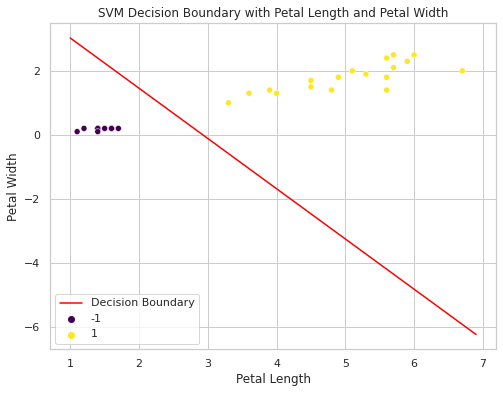

In [11]:
# Step 3: Extract parameters
w = svm.coef_[0]
b = svm.intercept_[0]

# Comvert w and b to m and q
m = -w[0] / w[1]
q = -b / w[1]

# Step 4: Plot the decision boundary and test data
sns.scatterplot(data=test_2d, x='petal_length', y='petal_width', hue='species', palette='viridis')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')

# Plot the decision boundary
x_values = np.linspace(min(train_2d['petal_length']), max(train_2d['petal_length']), 100)
y_values = m * x_values + q
plt.plot(x_values, y_values, color='red', label='Decision Boundary')

plt.title('SVM Decision Boundary with Petal Length and Petal Width')
plt.legend()
plt.show()

#### 2.7 **[2pt]** Classify the 2D dataset using the [scikit-learn implementation](https://scikit-learn.org/stable/modules/svm.html). Mandatory: (i) use the `LinearSVC` implementation (as we did not study kernels yet); (ii) use the same Loss function as in your hand-made implementation (should be easy enough to find), (iii) use a custom value of `C` that tends to ignore margin violations more than $1.0$, but without misclassifying data.

- SVC stands for "Support Vector (Machine) Classifier", while SVR uses the same trick for Regression (**do not** use it here).
- Class `LinearSVC` underneath uses the `liblinear` library, which is highly optimized for linear SVMs. Class `SVC` on the other hand uses `libsvm`, which is more optimized for nonlinear SVMs using kernels. In some cases you may actually get better results on the default parameters with `SVC(kernel='linear')` than you do with `LinearSVC()`, but the latter has a more flexible parametrization (for linear boundaries only), so eventually you should have more room for improvement (you can use a validation set to search for better hyperparaters).
- Remember that this question requires you to access the right datasets for training and test phases, and that you need to split the `x` and `y` as seen last week with NB (that's Naïve Bayes and yes next time you see NB that is what you should expect to mean). 
- You may be tempted to try passing a straight `0` to `C`. Many implementations give errors for `C=0`, but you can get around it by passing a good enough approximation :) remember you can use the scientific notation `1e-x` for decimals, but you really don't need it too small: with a low enough `C` you will start getting misclassified points! Give it a try: do you understand why this happens? (spoiler/hint: think about the English meaning of "maximizing the _margin_ without restrictions", how big a margin can you make if you wish to?)

In [12]:
from sklearn.svm import LinearSVC

# Train the SVM using LinearSVC
C_value = 1e-5
model = LinearSVC(C=C_value, loss='hinge')
model.fit(train_2d[['petal_length', 'petal_width']], train_2d['species'])

# Evaluate the model on the test set
misclassified = (model.predict(test_2d[['petal_length', 'petal_width']]) != test_2d['species']).sum()
print("Number of misclassified points in the test set:", misclassified)


Number of misclassified points in the test set: 10


#### 2.8 **[1pt]** Plot the decision boundary of the SVM over the dataset.

Think carefully and don't mess this up: _which dataset does the question refer to?_ Remember, from now on, we always split our initial data into (at least) two datasets, and all questions referring to learning the parameters use one of the two datasets, while all questions referring to showing the learned model performance should use the other.

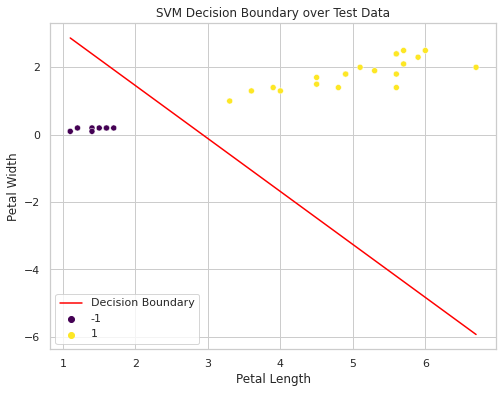

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot the test data points
sns.scatterplot(data=test_2d, x='petal_length', y='petal_width', hue='species', palette='viridis')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')

# Plot the decision boundary
x_values = np.linspace(min(test_2d['petal_length']), max(test_2d['petal_length']), 100)
y_values = (-w[0] / w[1]) * x_values - (b / w[1])  # Utiliser les paramètres w et b du SVM
plt.plot(x_values, y_values, color='red', label='Decision Boundary')

plt.title('SVM Decision Boundary over Test Data')
plt.legend()
plt.show()


# At the end of the exercise

Bonus question with no points! Answering this will have no influence on your scoring, not at the assignment and not towards the exam score -- really feel free to ignore it with no consequence. But solving it will reward you with skills that will make the next lectures easier, give you real applications, and will be good practice towards the exam.

The solution for this questions will not be included in the regular lab solutions pdf, but you are welcome to open a discussion on the Moodle: we will support your addressing it, and you may meet other students that choose to solve this, and find a teammate for the next assignment that is willing to do things for fun and not only for score :)

#### BONUS **[ZERO pt]** Train an SVM on the full Iris dataset (3 classes) using `libsvm`, and print the number of misclassified points. Play with `C` and see how this changes.

#### BONUS **[ZERO pt]** Train you hand-written SVM implementation using the [PEGASOS algorithm](https://github.com/ejlb/pegasos). Now you have a state-of-the-art implementation, congrats! It will actually run better than the scikit-learn `LinearSVM` and `SVC` implementations. Remember this when you need a quick ML result in the future, especially over large data, and performance matters!

To install pegasos (or any other GitHub repository) just switch to a local environment (as shown in the last lecture), then run (from your assignments folder):
```bash
python3 -m pipenv install -e 'git+https://github.com/ejlb/pegasos.git#egg=pegasos'
```
Here is probably the most complete [guide to Pipenv](https://realpython.com/pipenv-guide). I do not expect a full read (I didn't myself); but if you need something from Pipenv, a quick search in that page will likely point you in the right direction.

If you want to run on `colab`, this could be the right time for you to learn about using "bang commands" in Jupyter notebooks ("bang" being an exclamation mark `!`): they will be run in the shell that is running the Jupyter server. For example you can use `!pip install`. But as mentioned, this is just a hack as you have limited and blind control over your environment, and particularly it will give you problems as soon as you start collaborating with other people on other platforms (the solution is of course a local installation with Pipenv).

### Final considerations

- SVMs are optimal -- when applicable. In particular, if your data is bounded on all features, and you have enough samples from the whole range (so that new points in the test set are expected to be within the same range), then its performance are awesome. And if the data's underlying function is not overly complicated, you don't need an overly complicated model. In the real world and with real data, you are almost guaranteed to get to using a SVM for an application or another at some point in time.
- Remember that easy problems can be often solved with parameter guessing; this also means that if you can solve a problem with parameter guessing, it is an easy problem :) much depends on the model though, with the right model guessing the parameters is efficient, with the wrong model both guessing and training performance drops.
- The main limitation left at this point is handling non-linearities in the data. This is exactly the topic for the next lecture. Be ready as it is more math intensive than linear SVM, but you should have all the pieces now to grasp it completely in the next week.